In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import shuffle
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from datetime import datetime, timedelta
from sklearn import preprocessing
import random

In [3]:
df = pd.read_csv('AirQualityUCI.csv', sep=';')
df = df.drop('Unnamed: 15', 1)
df = df.drop('Unnamed: 16', 1)
df = df.dropna()
df.shape

(9357, 15)

In [4]:
# Create float from object
# and replace -200 outliers by mean of filtered column

obj_list = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

for col in obj_list:
    df[col] = df[col].apply(lambda x: str(x).replace(',', '.'))
    df[col] = df[col].astype(float)
    mean_clean = df[df[col] > -200][col].mean()
    df[col] = df[col].apply(lambda x: mean_clean if x== -200.0 else x)

In [5]:
# drop first 6 columns and create hourly datetimeindex

df = df[6:].copy().reset_index(drop=True)

date_series = pd.Series(
    pd.date_range("2004-03-11", periods=df.shape[0], freq="h")
)
df['date'] = date_series
df.index = pd.DatetimeIndex(df.date)

In [6]:
# drop unnecessary columns:

df = df.drop('Date', 1)
df = df.drop('date', 1)
df = df.drop('Time', 1)

In [7]:
# return correlations:

df.corr()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.444957,0.163247,0.812348,0.562122,0.626897,-0.524232,0.300579,0.356792,0.612113,0.020180,0.043272,0.043228
PT08.S1(CO),0.444957,1.000000,0.169281,0.570419,0.933279,0.278120,0.086510,0.153857,0.845187,0.892513,0.031758,0.073797,0.087680
NMHC(GT),0.163247,0.169281,1.000000,0.135196,0.110115,-0.004281,0.047625,0.102966,0.162450,0.100970,-0.066499,-0.014466,-0.121410
C6H6(GT),0.812348,0.570419,0.135196,1.000000,0.750267,0.516533,-0.575296,0.260617,0.556266,0.740102,0.198878,-0.061597,0.167916
PT08.S2(NMHC),0.562122,0.933279,0.110115,0.750267,1.000000,0.331275,-0.073694,0.176484,0.874800,0.909928,0.184467,-0.069035,0.142878
NOx(GT),0.626897,0.278120,-0.004281,0.516533,0.331275,1.000000,-0.436163,0.817223,0.035567,0.461920,-0.232412,0.107126,-0.201771
PT08.S3(NOx),-0.524232,0.086510,0.047625,-0.575296,-0.073694,-0.436163,1.000000,-0.256649,0.122585,-0.209127,-0.112976,-0.044654,-0.181021
NO2(GT),0.300579,0.153857,0.102966,0.260617,0.176484,0.817223,-0.256649,1.000000,-0.022265,0.253385,-0.136564,-0.080650,-0.252219
PT08.S4(NO2),0.356792,0.845187,0.162450,0.556266,0.874800,0.035567,0.122585,-0.022265,1.000000,0.723675,0.407923,-0.023431,0.457580
PT08.S5(O3),0.612113,0.892513,0.100970,0.740102,0.909928,0.461920,-0.209127,0.253385,0.723675,1.000000,-0.023113,0.106775,0.060602


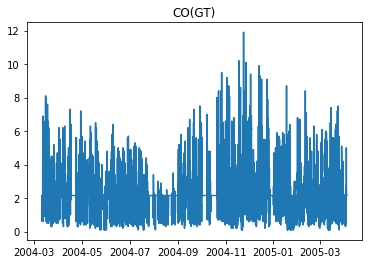

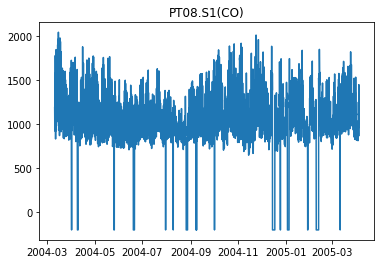

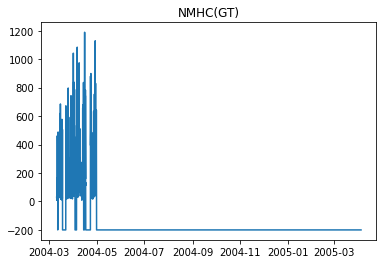

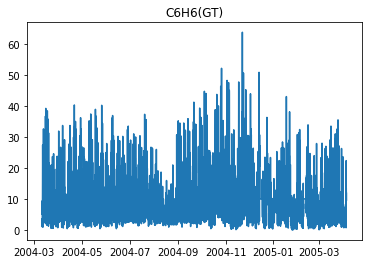

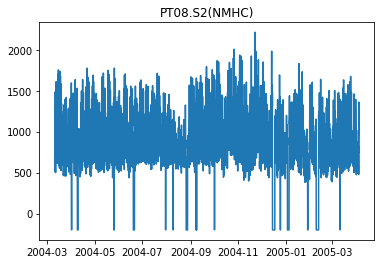

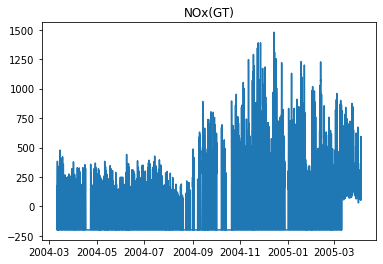

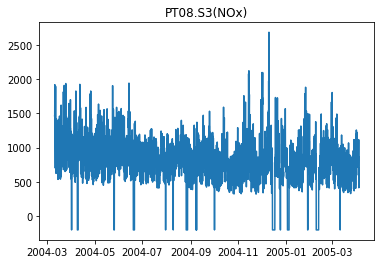

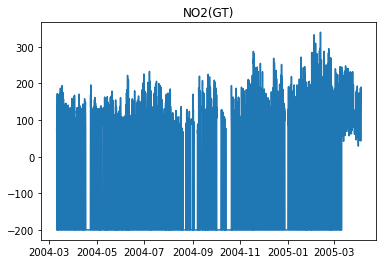

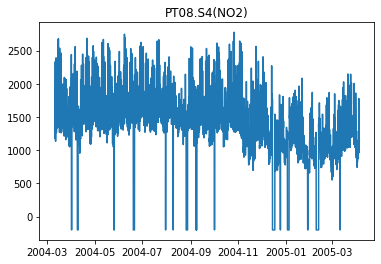

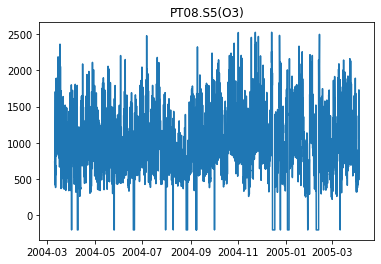

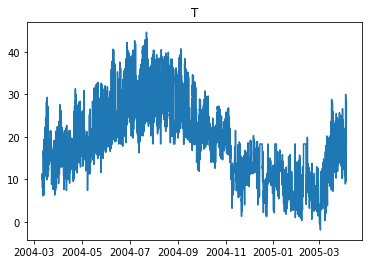

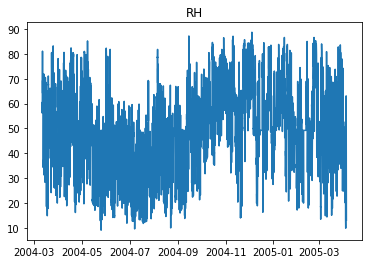

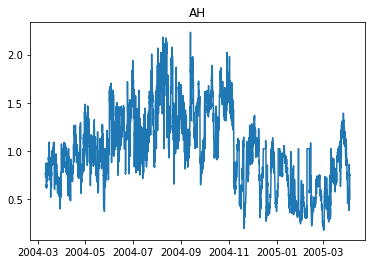

In [8]:
# Plot temperature to see if cleaned has worked
for col in df.columns:
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.show()

In [12]:


df2 = df[df.index>='2005-01-01'].copy()
df2['hour'] = df2.index.hour
df2['weekday'] = df2.index.weekday
df2['day'] = df2.index.day

In [17]:
time_info_list = ['hour', 'weekday', 'day']

for col in time_info_list:
    df2[col] = preprocessing.minmax_scale(df2[col], feature_range=(-0.5, 0.5))

In [45]:
features = ['C6H6(GT)', 
            'NOx(GT)',
            'hour',
            'weekday',
            'day']

target = ['CO(GT)']

In [678]:
num_periods_output = 10 #to predict
num_periods_input= 20 #input

In [679]:
def train_test_segment(df, 
                       train_length,
                       num_periods_input,
                       num_periods_output,
                       number_of_features):
    # cut training and testing 
    Train=df.iloc[0:train_length,:]
    Train=Train.values
    Train = Train.astype('float32')
    print('Traing length :',len(Train))
    Test=df.iloc[(train_length-num_periods_input):,:]
    Test=Test.values
    Test = Test.astype('float32')
    print('Test length :',len(Test))
    Number_Of_Features=number_of_features#
    
    # create train and test batches for X and y
    end=len(Train)
    start=0
    next=0
    x_batches=[]
    y_batches=[]  
    count=0
    while next+(num_periods_input)<end:
        next=start+num_periods_input
        x_batches.append(Train[start:next,:])
        y_batches.append(Train[next:next+num_periods_output,0])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, num_periods_output, 1)
    
    x_batches=np.asarray(x_batches) 
    x_batches = x_batches.reshape(-1, num_periods_input, Number_Of_Features) 
    
    # test batches
    end_test=len(Test)
    start_test=0
    next_test=0
    x_testbatches=[]
    y_testbatches=[]
    while next_test+(num_periods_input)<end_test:
        next_test=start_test+num_periods_input
        x_testbatches.append(Test[start_test:next_test,:])
        y_testbatches.append(Test[next_test:next_test+num_periods_output,0])
        start_test=start_test+num_periods_output
    y_testbatches=np.asarray(y_testbatches)
    y_testbatches = y_testbatches.reshape(-1, num_periods_output, 1)   
    x_testbatches=np.asarray(x_testbatches)
    x_testbatches = x_testbatches.reshape(-1, num_periods_input, Number_Of_Features) 
    
    return x_batches, y_batches, x_testbatches, y_testbatches

In [680]:
t_length = 2200
x_batches, y_batches,X_Test,Y_Test= train_test_segment(df2[target+features], 
                       t_length,
                       num_periods_input,
                       num_periods_output,
                       6)

Traing length : 2200
Test length : 67


In [681]:
#---------------------------
combined = list(zip(x_batches, y_batches))
random.shuffle(combined)
shuffled_batch_features, shuffled_batch_y = zip(*combined)

In [682]:
#xgboost part
All_Training_Instances=[]
 
#=============== flatten each training window into Instance 
#=================================
for i in range(0,len(shuffled_batch_features)):
    hold=[]
    temp=[]
    for j in range(0,len(shuffled_batch_features[i])):
    #**************** to run without features -->comment if else condition
    #(just keep else statement) **************************
      if j==(len(shuffled_batch_features[i])-1):
          hold=np.concatenate((hold, shuffled_batch_features[i][j][:]), axis=None)
          
      else:
          hold=np.concatenate((hold, shuffled_batch_features[i][j][0]), axis=None)
          
    All_Training_Instances.append(hold)

In [683]:
#=================================
All_Testing_Instances=[]
for i in range(0,len(X_Test)):
  hold=[]
  temp=[]
  for j in range(0,len(X_Test[i])):
  #**************** to run without features -->comment if else condition
#(just keep else statement) **************************
      if j==(len(X_Test[i])-1):
          hold=np.concatenate((hold, X_Test[i][j][:]), axis=None)
      else:
          hold=np.concatenate((hold, X_Test[i][j][0]), axis=None)
   
  All_Testing_Instances.append(hold)

print(len(All_Testing_Instances[0]))   

25


In [684]:
#=========================== final shape check =========================
All_Testing_Instances=np.reshape(All_Testing_Instances, (len(All_Testing_Instances),
                                                         len(All_Testing_Instances[0])))
Y_Test_Full=np.reshape(Y_Test_Full, (len(Y_Test_Full),num_periods_output))

All_Training_Instances=np.reshape(All_Training_Instances, (len(All_Training_Instances),
                                                        len(All_Training_Instances[0])))
shuffled_batch_y=np.reshape(shuffled_batch_y, (len(shuffled_batch_y),num_periods_output))


In [685]:
model=xgb.XGBRegressor(learning_rate =0.2,
 n_estimators=150,
 max_depth=8,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=1,
 seed=42,silent=False)

In [686]:
multioutput=MultiOutputRegressor(model).fit(All_Training_Instances,shuffled_batch_y)

/Users/janrathfelder/opt/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


[22:33:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:33:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:33:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

In [687]:
prediction=multioutput.predict(All_Testing_Instances)

In [695]:
#============================== PREDICTION ===============================
prediction=multioutput.predict(All_Testing_Instances)
mse = np.mean((prediction - Y_Test.reshape(Y_Test.shape[0],
                                           Y_Test.shape[1]))**2)
mae = np.mean(np.abs((prediction - Y_Test.reshape(Y_Test.shape[0],
                                           Y_Test.shape[1]))))

print('MAE: ',mae)
#print('With Features for {} weeks'.format(No_Of_weeks)) 
print('RMSE: ',mae**0.5)

MAE:  0.4790482
RMSE:  0.6921330742718976


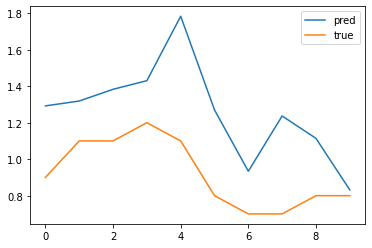

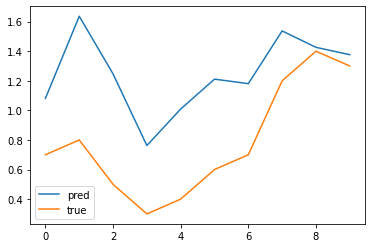

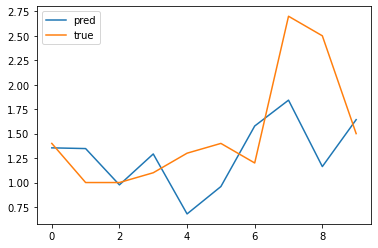

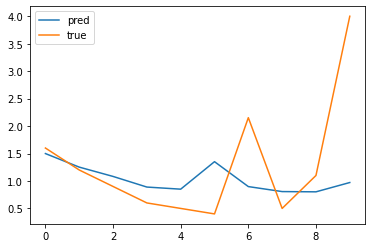

In [696]:
for i in range(len(prediction)):

    plt.plot(prediction[i], label='pred')
    plt.plot(Y_Test[i],label='true')
    plt.legend()
    plt.show()